In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../capstone"))

['Untitled1.ipynb', '.DS_Store', 'requirements.txt', 'whales-Copy2.ipynb', 'Untitled.ipynb', 'models', 'Capstone.ipynb', 'whales-Copy1.ipynb', 'README.md', 'proposal.pdf', 'whales.ipynb', '.ipynb_checkpoints', 'data']


In [5]:
img_train_path = os.path.abspath('../capstone/data/train/')
img_test_path = os.path.abspath('../capstone/data/test/')
csv_train_path = os.path.abspath('../capstone/data/train.csv')

In [6]:
df = pd.read_csv(csv_train_path, index_col='Image')
df.head()

Id
Image                   
0000e88ab.jpg  w_f48451c
0001f9222.jpg  w_c3d896a
00029d126.jpg  w_20df2c5
00050a15a.jpg  new_whale
0005c1ef8.jpg  new_whale

Lets add the image path to the train df so its all in one place

In [7]:
df['Image_path'] = [os.path.join(img_train_path,whale) for whale in df.index]
df.head()

Id                                         Image_path
Image                                                                      
0000e88ab.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
0001f9222.jpg  w_c3d896a  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
00029d126.jpg  w_20df2c5  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
00050a15a.jpg  new_whale  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
0005c1ef8.jpg  new_whale  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...

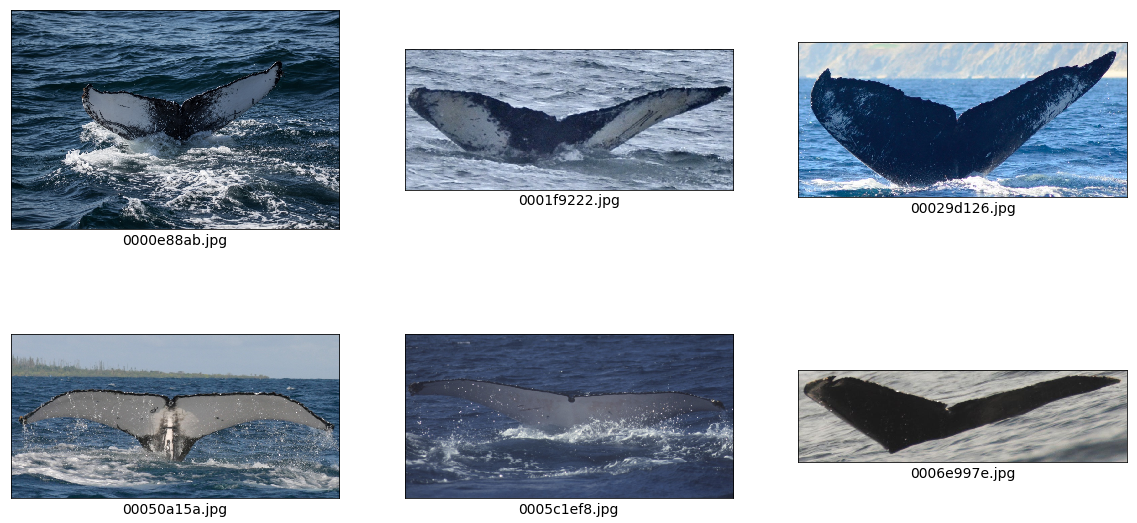

In [8]:
import cv2                
import matplotlib.pyplot as plt     
from matplotlib.colors import NoNorm
%matplotlib inline  

fig = plt.figure(figsize=(20,10))    
for i in range (0,6):
    img = cv2.imread(df.Image_path[i])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(2, 3, i+1, xticks=[], yticks=[])
    ax.set_xlabel(df.index[i], fontsize=14)
    ax.imshow(cv_rgb)

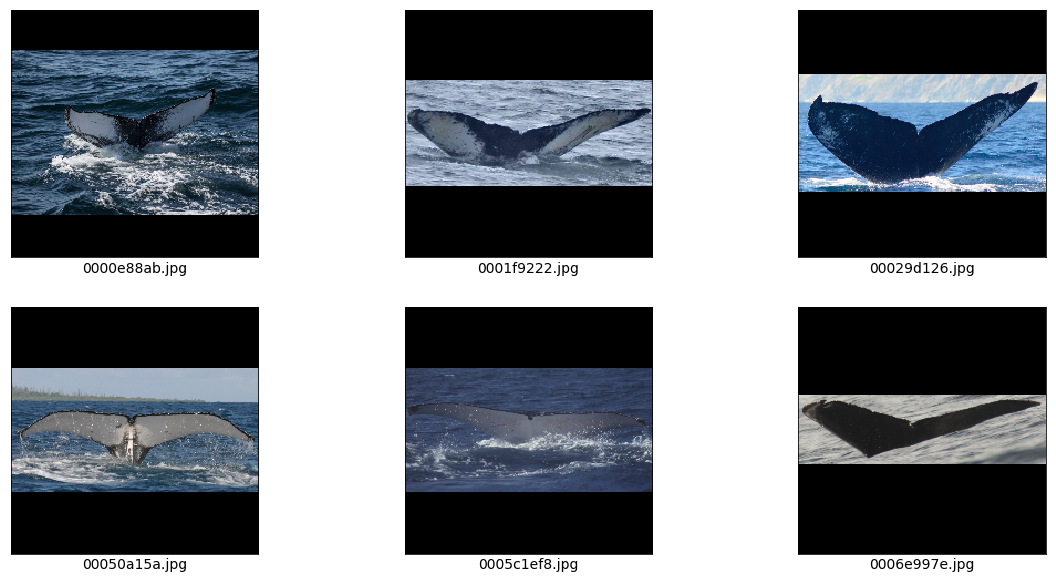

In [9]:
#test reshaping with padding
# Thanks https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
def image_processing(img_path):
    desired_size = 224
    im_pth = img_path

    im = cv2.imread(im_pth)
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return new_im

def image_processing_add_pad(im):
    desired_size = 224
#     im = img
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return new_im


fig = plt.figure(figsize=(20,10))    
for i in range (0,6):
    img = image_processing(df.Image_path[i])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(2, 3, i+1, xticks=[], yticks=[])
    ax.set_xlabel(df.index[i], fontsize=14)
    ax.imshow(cv_rgb)


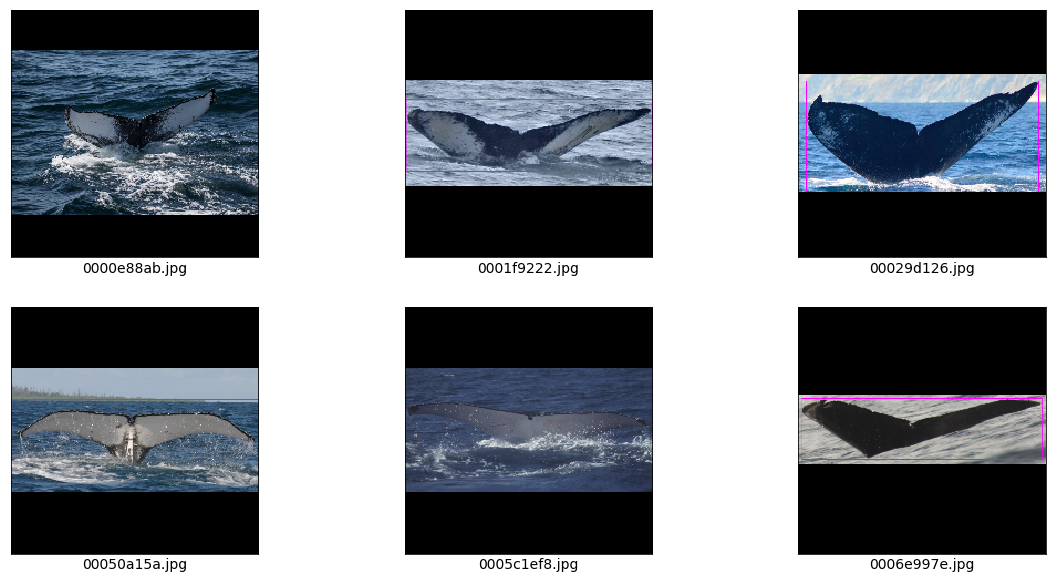

In [10]:
# Test converting to a gray image and using that for a boundary box

fig = plt.figure(figsize=(20,10))    
for i in range (0,6):
    img = cv2.imread(df.Image_path[i])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # grayscale
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # rgb
    #Define threshold, needs to differentiate between sea and whales so 50/50 not suitable
    _,thresh = cv2.threshold(gray,80,255,cv2.THRESH_BINARY_INV) #threshold
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    dilated = cv2.dilate(thresh,kernel,iterations = 5) # dilate
    contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
    # get contours
    # for each contour found, draw a rectangle around it on original image
    for contour in contours:
        # get rectangle bounding contour
        [x,y,w,h] = cv2.boundingRect(contour)
        # discard areas that are too large
        if h>500 and w>500:
            continue
        # discard areas that are too small 
        if h<80 or w<80:
            continue
        # draw rectangle around contour on original image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)
    #Then add the padding
    new_img = image_processing_add_pad(img)
    rgb = cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(2, 3, i+1, xticks=[], yticks=[])
    ax.set_xlabel(df.index[i], fontsize=14)
    rgb = cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB) # rgb
    ax.imshow(rgb)


    

In [12]:
#Padding and Boundary box
def image_processing_box(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # grayscale
#     rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # rgb
    #Define threshold, needs to differentiate between sea and whales so 50/50 not suitable
    _,thresh = cv2.threshold(gray,80,255,cv2.THRESH_BINARY_INV) #threshold
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    dilated = cv2.dilate(thresh,kernel,iterations = 5) # dilate
    contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
    # get contours
    # for each contour found, draw a rectangle around it on original image
    for contour in contours:
        # get rectangle bounding contour
        [x,y,w,h] = cv2.boundingRect(contour)
        # discard areas that are too large
        if h>500 and w>500:
            continue
        # discard areas that are too small 
        if h<80 or w<80:
            continue
        # draw rectangle around contour on original image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)
    desired_size = 224
    old_size = img.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    img = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return new_im    

img = image_processing_box('/home/ubuntu/kaggle/train/00050a15a.jpg')
# convert BGR image to grayscale
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()    
    

error: OpenCV(4.0.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [13]:
#data investigation

# Collecting count of WhaleIDs
print ("total number of unique whale Id's", len(df.Id.unique()))
display(df.Id.value_counts().head(10))

new_whales = df[df.Id == 'new_whale']
total_whales = (df.Id.count())
none_new_whales = df[df.Id != 'new_whale']

# display(none_new_whales)
group_filter = none_new_whales.groupby('Id')
# #remove those whales which are only spotted once
set_to_use = group_filter.filter(lambda x: len(x) > 1)
whales_to_drop = group_filter.filter(lambda x: len(x) <= 1)

# all whales
print ('total whales ', total_whales)

#new_whales
print ('new_whales count ', new_whales.Id.count())
#percentage of new whales
print ('Percentage of whales labeled as new_whale ', round((new_whales.Id.count()/total_whales)*100) )

#none new_whales
print ('none_new_whale count ', none_new_whales.Id.count())

#whales with a single entry
# single_whales = len(df.Id.value_counts().reset_index(name="count").query("count > 1")["index"])
print ('number of whales labelled only once ',whales_to_drop.Id.count())
print ("total number of unique whale Id's seen once", len(whales_to_drop.Id.unique()))

print ('number of whales labelled more than once ',set_to_use.Id.count())
print ("total number of unique whale Id's seen more than once", len(set_to_use.Id.unique()))


("total number of unique whale Id's", 5005)


new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
w_700ebb4      57
w_3de579a      54
w_564a34b      51
w_fd3e556      50
w_88e4537      49
Name: Id, dtype: int64

('total whales ', 25361)
('new_whales count ', 9664)
('Percentage of whales labeled as new_whale ', 0.0)
('none_new_whale count ', 15697)
('number of whales labelled only once ', 2073)
("total number of unique whale Id's seen once", 2073)
('number of whales labelled more than once ', 13624)
("total number of unique whale Id's seen more than once", 2931)


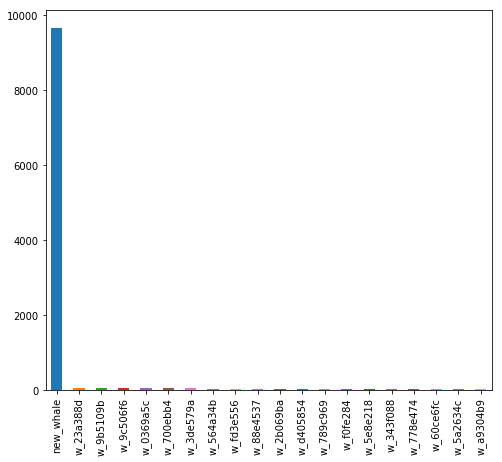

In [14]:
df['Id'].value_counts()[0:20].plot.bar(figsize=(8, 7))

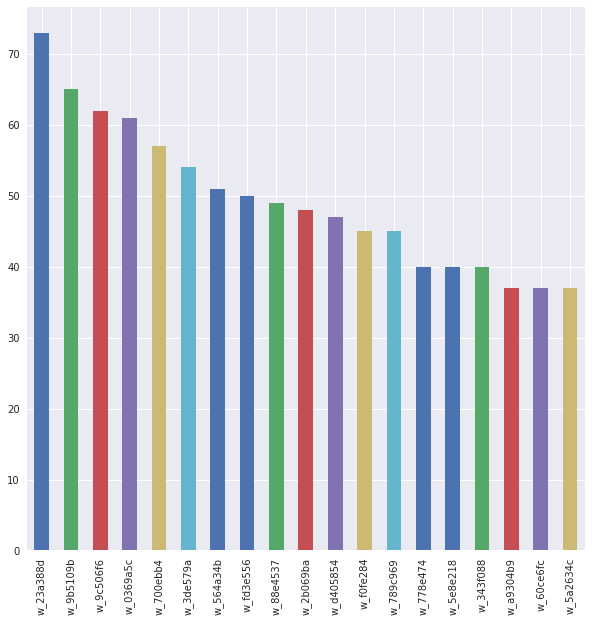

In [68]:
df['Id'].value_counts()[1:20].plot.bar(figsize=(10, 10))


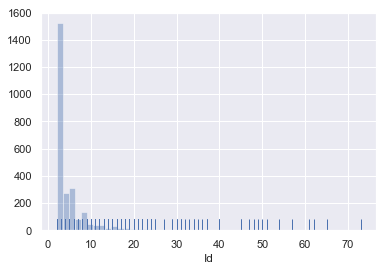

In [15]:
import seaborn as sns
sns.set(color_codes=True)

sns.distplot(df['Id'].value_counts()[1:2600], kde=False, rug=True)

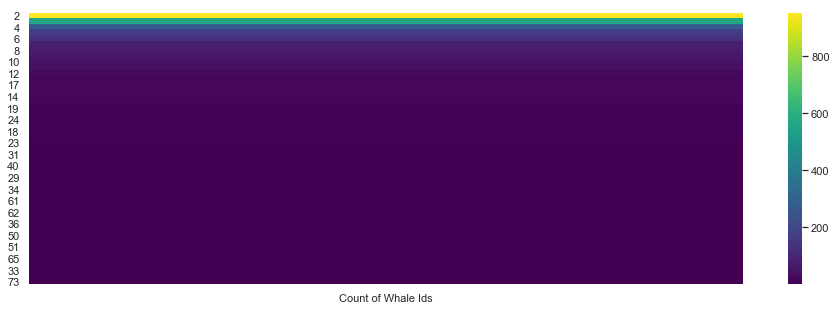

In [16]:
#create a heatmap showing how many times a specific whale is identified
#count how many times each ID is seen
count = df['Id'].value_counts()[1:2600]

#count how many times that specific 'count' has been seen
final_count = count.value_counts()
col = (final_count.values)

cols = ['Count of Whale Ids']
heatmap = pd.DataFrame(index=final_count.index, data=col, columns=cols)
    
plt.figure(figsize=(16,5))
ax = sns.heatmap(heatmap, fmt="g", cmap='viridis')

Many whales identified as 'new_whale' will make training difficult.  Similarly with the training data I have, I cannot train/test of whales where there is only one image lets train the model on the ones we know, then extend from there

Lets do some one_hot encoding

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded, integer_encoded, label_encoder

y_ones_hot, integer_encoded, label_encoder = prepare_labels(set_to_use.Id)

first_whale_count = set_to_use.Id.loc[set_to_use['Id']== set_to_use.Id[0]].count()
print ("\nThe first whale is identified ", first_whale_count, "times")
display(set_to_use.loc[set_to_use['Id']== set_to_use.Id[0]])

('\nThe first whale is identified ', 14, 'times')


Id                                         Image_path
Image                                                                      
0000e88ab.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
0af805558.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
1c351b88e.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
6f7abb1be.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
77a44bf94.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
79c77838d.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
9064d5875.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
9fc84d2ae.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
c1ec12eb6.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
c64e5e861.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
c9df69a69.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
db0699767.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
e2f1b6c4a.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...
e3f2dbd25.jpg  w_f48451c  /Users/hwatson/git/Udacity/Udacity_MLND/capsto...

Verify ones_hot encoding

In [18]:
def ones_hot_lookup(image_name):
    index = set_to_use.index.get_loc(image_name)
    int_ecoded = integer_encoded[index][0]
    ones_hot = y_ones_hot[index][int_ecoded]
    return index, int_ecoded, ones_hot

print ('y_ones_hot of first entry on entry',integer_encoded[0][0],'is', y_ones_hot[0][integer_encoded[0][0]])
print ('now lets check all the images to make sure the encoding is ok')
print('image , index , Int_encoded , one_hot')
temp_df = set_to_use.loc[set_to_use['Id']== set_to_use.Id[0]]
for index in temp_df.iterrows():
    test_index, test_enc, ones_hot = ones_hot_lookup(index[0])
    print (index[0],',',test_index,',',test_enc,',',ones_hot)

('y_ones_hot of first entry on entry', 2810, 'is', 1.0)
now lets check all the images to make sure the encoding is ok
image , index , Int_encoded , one_hot
('0000e88ab.jpg', ',', 0, ',', 2810, ',', 1.0)
('0af805558.jpg', ',', 584, ',', 2810, ',', 1.0)
('1c351b88e.jpg', ',', 1433, ',', 2810, ',', 1.0)
('6f7abb1be.jpg', ',', 5821, ',', 2810, ',', 1.0)
('77a44bf94.jpg', ',', 6239, ',', 2810, ',', 1.0)
('79c77838d.jpg', ',', 6362, ',', 2810, ',', 1.0)
('9064d5875.jpg', ',', 7630, ',', 2810, ',', 1.0)
('9fc84d2ae.jpg', ',', 8429, ',', 2810, ',', 1.0)
('c1ec12eb6.jpg', ',', 10272, ',', 2810, ',', 1.0)
('c64e5e861.jpg', ',', 10527, ',', 2810, ',', 1.0)
('c9df69a69.jpg', ',', 10747, ',', 2810, ',', 1.0)
('db0699767.jpg', ',', 11660, ',', 2810, ',', 1.0)
('e2f1b6c4a.jpg', ',', 12083, ',', 2810, ',', 1.0)
('e3f2dbd25.jpg', ',', 12133, ',', 2810, ',', 1.0)


lets make a Train/Validation/Test split on the Training data

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(set_to_use, y_ones_hot, test_size=0.20, random_state=42)

#lets break down the Train set further into a Train/Validate set
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

print ('Train X/y shape ', X_train.shape, y_train.shape)
print ('Validate X/y shape ', X_validate.shape, y_validate.shape)
print ('Test X/y shape ', X_test.shape, y_test.shape)
print ('shape of a single y entry ', y_train[0].shape)

('Train X/y shape ', (8719, 2), (8719, 2931))
('Validate X/y shape ', (2180, 2), (2180, 2931))
('Test X/y shape ', (2725, 2), (2725, 2931))
('shape of a single y entry ', (2931,))


Double check the ones_hot validity

In [20]:
#choose 100'th image as a test
print ('sample whales_file '+ X_train.index[100])
img_index, img_int, img_ones_hot = ones_hot_lookup(X_train.index[100])
print ('Index, Integer, Ones_hot from the full set_to_use DF',img_index, img_int, img_ones_hot)
print ('Confirm ones_hot of y_train matches', y_train[100][img_int])

sample whales_file 5b199a5d0.jpg
('Index, Integer, Ones_hot from the full set_to_use DF', 4730, 2444, 1.0)
('Confirm ones_hot of y_train matches', 1.0)


In [21]:
#check the shape of the X_train and y_train 
print ('shape of X_train '+ str(X_train.shape))
print ('shape of y_train '+ str(y_train.shape))

shape of X_train (8719, 2)
shape of y_train (8719, 2931)


In [23]:
from PIL import Image, ImageOps
from keras.preprocessing import image  
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


def path_to_tensor_pad(img_path):
    #add the padding with the CV2 processing method
    img = image_processing(img_path)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def path_to_tensor_box(img_path):
    #add the padding with the CV2 processing method
    img = image_processing_box(img_path)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)


## Since ResNet50 only handles 3D images converting and/or duplicating dimensions doesn't seem worthwhile ##
def paths_to_tensor_gray(img_paths):
    list_of_tensors = [path_to_tensor_gray(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

def path_to_tensor_gray(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale')
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)


In [28]:
X_train_images = paths_to_tensor(X_train.Image_path)

100%|██████████| 8719/8719 [01:40<00:00, 86.56it/s]


In [29]:
X_validate_images = paths_to_tensor(X_validate.Image_path)

100%|██████████| 2180/2180 [00:24<00:00, 88.66it/s]


In [24]:
X_test_images = paths_to_tensor(X_test.Image_path)

100%|██████████| 2725/2725 [01:03<00:00, 42.88it/s]


In [25]:
print (X_test_images.shape)
print (X_test_images.shape[1:])
print (y_train.shape[1])
print (y_ones_hot.shape[1])
print (y_train.shape[1])
# X /=255
# X_validate /=255


(2725, 224, 224, 3)
(224, 224, 3)
2931
2931
2931


In [26]:
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model

#transfer learning
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [108]:
# base_model=ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3)) 
base_model=ResNet50(weights='imagenet',include_top=False) 
base_model.summary()
len(base_model.layers)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

175

In [109]:
#Allow Layer5 of ResNet50 to be trainable
for layer in base_model.layers[171:]:
    layer.trainable = True
for layer in base_model.layers[:171]:
    layer.trainable = False
    
i = 0
for layer in base_model.layers:
    print(i, layer.name, layer.trainable)
    i = i +1

0 input_8 False
1 conv1_pad False
2 conv1 False
3 bn_conv1 False
4 activation_344 False
5 pool1_pad False
6 max_pooling2d_8 False
7 res2a_branch2a False
8 bn2a_branch2a False
9 activation_345 False
10 res2a_branch2b False
11 bn2a_branch2b False
12 activation_346 False
13 res2a_branch2c False
14 res2a_branch1 False
15 bn2a_branch2c False
16 bn2a_branch1 False
17 add_113 False
18 activation_347 False
19 res2b_branch2a False
20 bn2b_branch2a False
21 activation_348 False
22 res2b_branch2b False
23 bn2b_branch2b False
24 activation_349 False
25 res2b_branch2c False
26 bn2b_branch2c False
27 add_114 False
28 activation_350 False
29 res2c_branch2a False
30 bn2c_branch2a False
31 activation_351 False
32 res2c_branch2b False
33 bn2c_branch2b False
34 activation_352 False
35 res2c_branch2c False
36 bn2c_branch2c False
37 add_115 False
38 activation_353 False
39 res3a_branch2a False
40 bn3a_branch2a False
41 activation_354 False
42 res3a_branch2b False
43 bn3a_branch2b False
44 activation_355 Fa

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.02,
                                    zoom_range=[0.9, 1.25],
                                    horizontal_flip=False,
                                    fill_mode='constant',
                                    brightness_range=[0.5, 1.5])

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

#Create the image generators
batch_size = 512
train_generator = train_datagen.flow(X_train_images, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_validate_images, y_validate, batch_size=batch_size)

In [111]:
mymodel = Sequential()
mymodel.add(base_model)
mymodel.add(GlobalAveragePooling2D(input_shape=X_train_images.shape[1:]))
# mymodel.add(layers.Dense(512,activation='relu'))
mymodel.add(layers.Dense(y_train.shape[1],activation='sigmoid'))

mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2931)              6005619   
Total params: 29,593,331
Trainable params: 7,060,339
Non-trainable params: 22,532,992
_________________________________________________________________


In [112]:
from keras.optimizers import Adam
# Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1)
mymodel.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print ("How many weights in the model are trainable?", len(mymodel.trainable_weights))

How many weights in the model are trainable? 6


In [124]:
ntrain = len(X_train_images)
nval = len(X_validate_images)
history = mymodel.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/5
17/17 [==============================] - 107s 6s/step - loss: 0.3943 - acc: 0.9424 - val_loss: 8.3415 - val_acc: 0.0000e+00
Epoch 2/5
17/17 [==============================] - 91s 5s/step - loss: 0.3593 - acc: 0.9498 - val_loss: 8.3406 - val_acc: 9.7656e-04
Epoch 3/5
17/17 [==============================] - 86s 5s/step - loss: 0.3606 - acc: 0.9520 - val_loss: 8.3734 - val_acc: 0.0000e+00
Epoch 4/5
17/17 [==============================] - 90s 5s/step - loss: 0.3185 - acc: 0.9558 - val_loss: 8.3187 - val_acc: 0.0000e+00
Epoch 5/5
17/17 [==============================] - 88s 5s/step - loss: 0.2951 - acc: 0.9596 - val_loss: 8.3581 - val_acc: 0.0000e+00


In [98]:
#Save the model
mymodel.save_weights('models/resnet_model_weights_trainable_layers_adam_512_20epoc.h5')
mymodel.save('models/resnet_model_keras_trainable_layers_adam_512_20epoc.h5')

In [27]:
#Load model when training done
mymodel = load_model('data/models/resnet_model_keras_trainable_layers_adam_512.h5')
# mymodel.load_weights('resnet_model_weights_reduced_whales_512_v2.h5')

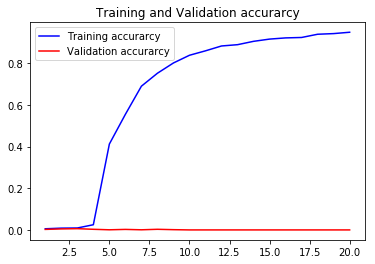

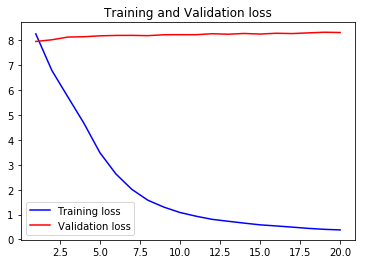

In [99]:
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [28]:
preds = mymodel.predict(X_test_images)

In [29]:
correct = 0
correct_values = []
actual_values = []
correct_y = []
correct_x = []

depth = 5
for i in range (len(preds)):
    actual_values.append(label_encoder.inverse_transform(preds[i].argsort()[-depth:][::-1]))
    if X_test.Id[i] in label_encoder.inverse_transform(preds[i].argsort()[-depth:]):
        correct_y.append(X_test.Id[i])
        correct_x.append(label_encoder.inverse_transform(preds[i].argsort()[-depth:][::-1]))
        correct_values.append((X_test.Id[i], 'found', label_encoder.inverse_transform(preds[i].argsort()[-depth:][::-1]), preds[i].argsort()[-depth:][::-1]))
        correct = correct +1

In [30]:
print (len(correct_values), 'whales correctly identified out of ', len(preds))
print ('Example\nWhale ID ',correct_y[0])
print ('found in predictions', correct_x[0])
# print ('detected in ', preds[0].argsort()[-5:][::-1])
print ('highest value ',preds[0].max())

(188, 'whales correctly identified out of ', 2725)
('Example\nWhale ID ', 'w_3de579a')
('found in predictions', array(['w_c815410', 'w_3de579a', 'w_c058057', 'w_b5e6c80', 'w_0135f5f'], dtype=object))
('highest value ', 4.6010049e-05)


In [31]:
#MAP@5 Calculation, thanks to https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def apk(actual, predicted, k=20):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

#     for i,p in enumerate(predicted):
#         if p in actual:
#             return 1.0
            
    if not actual:
        return 0.0

    return score / min(len(actual), k)
#     return score

def mapk(actual, predicted, k=20):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


In [32]:
mapk_calc = mapk(X_test.Id, actual_values, 5)

In [33]:
print ('Number of whales detected, MAP@5')
print (len(correct_values), mapk_calc)

Number of whales detected, MAP@5
(188, 0.0084073394495412825)


How does our accuracy and MAP change if we gradually increase the number of predictions?

In [35]:
def get_maps(pred_number):
    total_correct = []
    map_scores = []
    for j in range (1,pred_number+1):
        map_scores.append(mapk(X_test.Id, actual_values, j))
    return map_scores

maps = get_maps(20)

In [36]:
display(maps)

[0.027522935779816515,
 0.017339449541284403,
 0.012782874617737002,
 0.010160550458715596,
 0.0084073394495412825,
 0.0070061162079510702,
 0.0060052424639580604,
 0.0052545871559633028,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462,
 0.0046707441386340462]

In [37]:
def get_accuracy(depth):
    correct = 0
    correct_values = []
    actual_values = []
    correct_y = []
    correct_x = []
    for i in range (len(preds)):
        actual_values.append(label_encoder.inverse_transform(preds[i].argsort()[-depth:][::-1]))
        if X_test.Id[i] in label_encoder.inverse_transform(preds[i].argsort()[-depth:]):
            correct_y.append(X_test.Id[i])
            correct_x.append(label_encoder.inverse_transform(preds[i].argsort()[-depth:][::-1]))
            correct_values.append((X_test.Id[i], 'found', label_encoder.inverse_transform(preds[i].argsort()[-depth:][::-1]), preds[i].argsort()[-depth:][::-1]))
            correct = correct +1
    return correct

correct_answers = []
for i in range(1,21):
    correct_answers.append(get_accuracy(i))

In [38]:
print(correct_answers)

[75, 114, 144, 169, 188, 210, 224, 247, 267, 282, 288, 299, 317, 329, 350, 359, 370, 379, 388, 398]


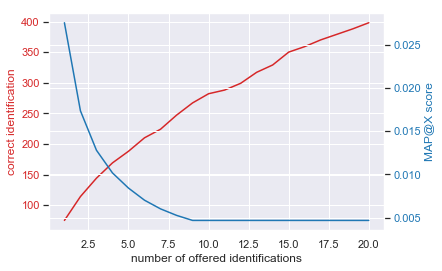

In [39]:
t = np.arange(1,21,1)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('number of offered identifications')
ax1.set_ylabel('correct identification', color=color)
ax1.plot(t, correct_answers, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('MAP@X score', color=color)
ax2.plot(t, maps, color=color)
ax2.tick_params(axis='y', labelcolor=color)